In [1]:
import warnings
warnings.filterwarnings("ignore")

import logging
import pandas as pd
import os
import gzip

from datetime import datetime
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [3]:
####################################################
############# Setear segun cada maquina ############
os.chdir("C:/diego_tools/labo3/dataset")
####################################################

In [4]:
def error_rate(y, y_pred):
    dif_abs = sum(abs(y - y_pred))
    suma_real = sum(y)
    
    return round(100*dif_abs/suma_real,2)

In [5]:
def print_error_rate_total_y_cat(df_pred):
    error_rate_total = error_rate(df_pred.tn_real,df_pred.tn_pred)
    printmd("**Error Rate Total:** " + str(error_rate_total))

    for cat1_iter in df_pred.cat1.unique():
        df_pred_cat = df_pred[df_pred.cat1 == cat1_iter]
        error_rate_cat = error_rate(df_pred_cat.tn_real,df_pred_cat.tn_pred)
        printmd("**Error Rate por Categoría " + cat1_iter + "**: " + str(error_rate_cat))

In [6]:
df_sellout = pd.read_csv("emp3_sellout_base_period_product.csv")

In [7]:
df_sellout.head()

,periodo,periodo_fecha,product_id,tn,cust_request_qty,cust_request_tn,plan_precios_cuidados,cat1,cat2,cat3,sku_size,temp_media,temp_max_media,temp_min_media,IPC,promedio_mens_dolar_venta,catastrofe
0,201701,2017-01-01,20001,934.77222,479,937.72717,0,HC,ROPA LAVADO,Liquido,3000.0,25.65,30.4,20.9,1.6,15.91,False
1,201701,2017-01-01,20002,550.15707,391,555.18654,0,HC,ROPA LAVADO,Liquido,3000.0,25.65,30.4,20.9,1.6,15.91,False
2,201701,2017-01-01,20003,1063.45835,438,1067.81543,0,FOODS,ADEREZOS,Mayonesa,475.0,25.65,30.4,20.9,1.6,15.91,False
3,201701,2017-01-01,20004,555.91614,339,569.37394,0,FOODS,ADEREZOS,Mayonesa,240.0,25.65,30.4,20.9,1.6,15.91,False
4,201701,2017-01-01,20005,494.27011,249,494.60084,0,FOODS,ADEREZOS,Mayonesa,120.0,25.65,30.4,20.9,1.6,15.91,False


In [8]:
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31243 entries, 0 to 31242
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   periodo                    31243 non-null  int64  
 1   periodo_fecha              31243 non-null  object 
 2   product_id                 31243 non-null  int64  
 3   tn                         31243 non-null  float64
 4   cust_request_qty           31243 non-null  int64  
 5   cust_request_tn            31243 non-null  float64
 6   plan_precios_cuidados      31243 non-null  int64  
 7   cat1                       31243 non-null  object 
 8   cat2                       31243 non-null  object 
 9   cat3                       31243 non-null  object 
 10  sku_size                   31243 non-null  float64
 11  temp_media                 31243 non-null  float64
 12  temp_max_media             31243 non-null  float64
 13  temp_min_media             31243 non-null  flo

In [9]:
df_sellout.cat1.value_counts()

PC             16779
HC              7603
FOODS           6632
desconocida      229
Name: cat1, dtype: int64

In [10]:
# Selecciono las columnas iniciales
df_sellout = df_sellout[["periodo","product_id","tn","cat1"]]

Verificación de producto estrella --> ok

## Split train y test

In [11]:
df_train = df_sellout[df_sellout.periodo <= 201902]
df_test = df_sellout[df_sellout.periodo == 201904]

In [12]:
df_train

,periodo,product_id,tn,cat1
0,201701,20001,934.77222,HC
1,201701,20002,550.15707,HC
2,201701,20003,1063.45835,FOODS
3,201701,20004,555.91614,FOODS
4,201701,20005,494.27011,FOODS
...,...,...,...,...
21988,201902,21261,0.04656,PC
21989,201902,21262,0.05786,PC
21990,201902,21263,0.05927,PC
21991,201902,21264,0.01378,FOODS


In [13]:
print(len(df_test))
df_test

919


,periodo,product_id,tn,cat1
22888,201904,20001,1647.63848,HC
22889,201904,20002,1287.62346,HC
22890,201904,20003,565.33774,FOODS
22891,201904,20004,466.70901,FOODS
22892,201904,20005,624.99880,FOODS
...,...,...,...,...
23802,201904,21266,0.36178,PC
23803,201904,21267,0.12291,PC
23804,201904,21269,0.11351,PC
23805,201904,21271,0.00185,FOODS


In [14]:
product_id_nuevos = set(df_test.product_id).difference(set(df_train.product_id))
len(product_id_nuevos)

50

Hay 50 productos NUEVOS (están en 201904 y no antes)

Entonces vamos a predecir 919-50 => 869

In [15]:
df_test = df_test[~df_test.product_id.isin(product_id_nuevos)]
len(df_test)

869

## Predicción Arima

In [16]:
# Convierto columna periodo en fecha
df_train["periodo"] = pd.to_datetime(df_train.periodo,format="%Y%m")
df_train.tail()

,periodo,product_id,tn,cat1
21988,2019-02-01,21261,0.04656,PC
21989,2019-02-01,21262,0.05786,PC
21990,2019-02-01,21263,0.05927,PC
21991,2019-02-01,21264,0.01378,FOODS
21992,2019-02-01,21271,0.01041,FOODS


In [17]:
df_arima_pred = pd.DataFrame(columns=["product_id","cat1","tn_real","tn_pred"])

0 ) 20001


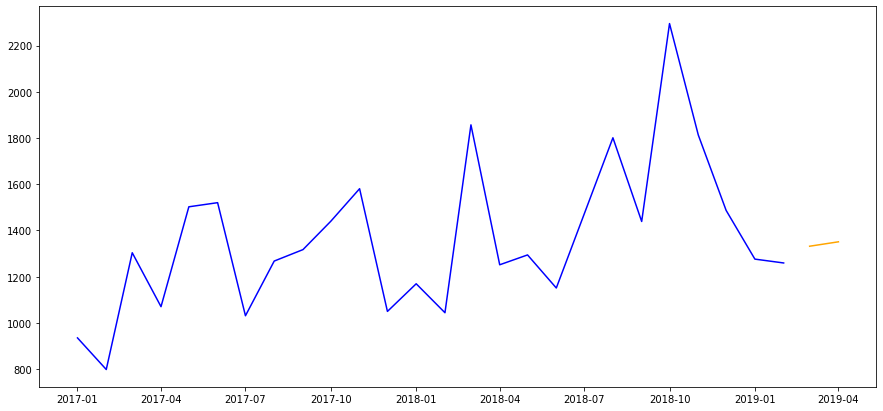

10 ) 20011
20 ) 20021
30 ) 20031


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


40 ) 20041
50 ) 20051
60 ) 20061
70 ) 20071
80 ) 20081


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


90 ) 20091
100 ) 20102


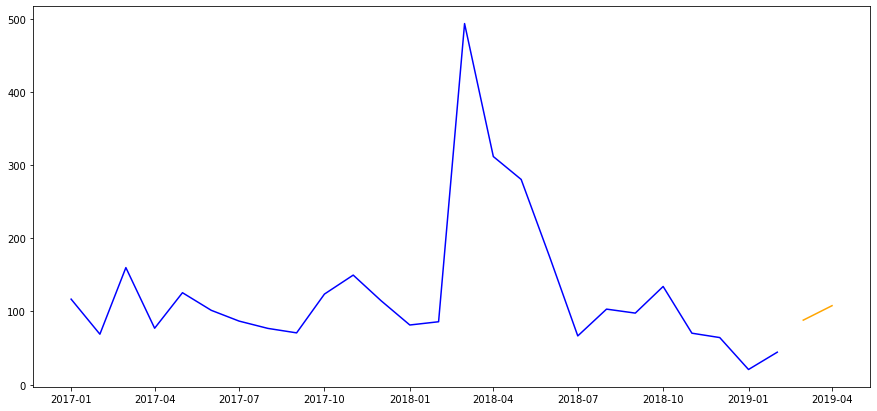

110 ) 20114
120 ) 20124
130 ) 20135
140 ) 20146
150 ) 20157
160 ) 20167
170 ) 20178
180 ) 20188


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


190 ) 20198
200 ) 20211


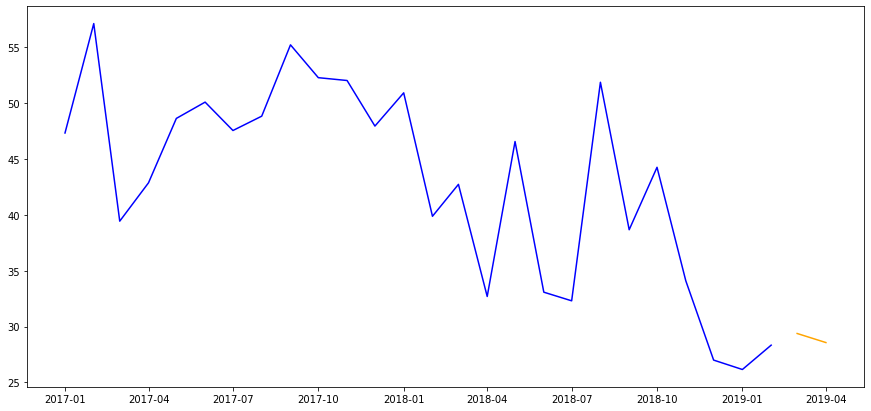

210 ) 20222
220 ) 20233
230 ) 20246
240 ) 20259
250 ) 20271
260 ) 20282
270 ) 20293
280 ) 20304


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


290 ) 20314
300 ) 20324


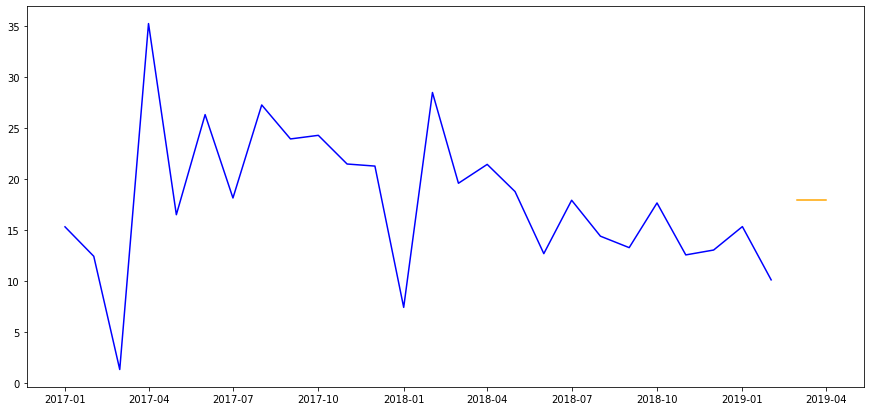

310 ) 20336
320 ) 20348
330 ) 20359
340 ) 20369
350 ) 20382
360 ) 20393
370 ) 20403
380 ) 20413
390 ) 20424


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


400 ) 20435


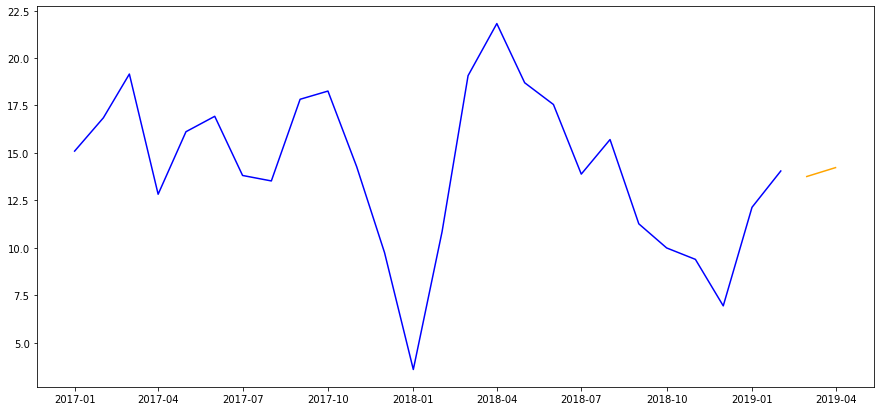

410 ) 20449


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


420 ) 20463


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


430 ) 20474
440 ) 20485
450 ) 20501
460 ) 20516
470 ) 20532
480 ) 20543
490 ) 20558


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


500 ) 20569


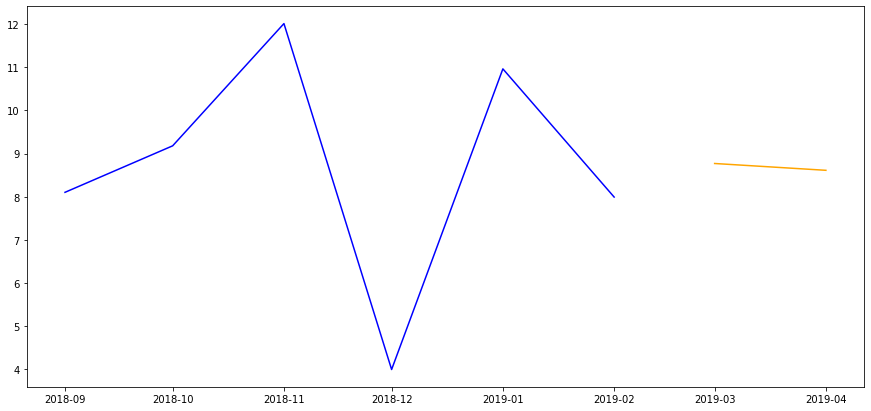

510 ) 20582


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


520 ) 20596
530 ) 20607


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


540 ) 20625
550 ) 20639


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


560 ) 20651
570 ) 20663


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


580 ) 20678
590 ) 20697
600 ) 20710


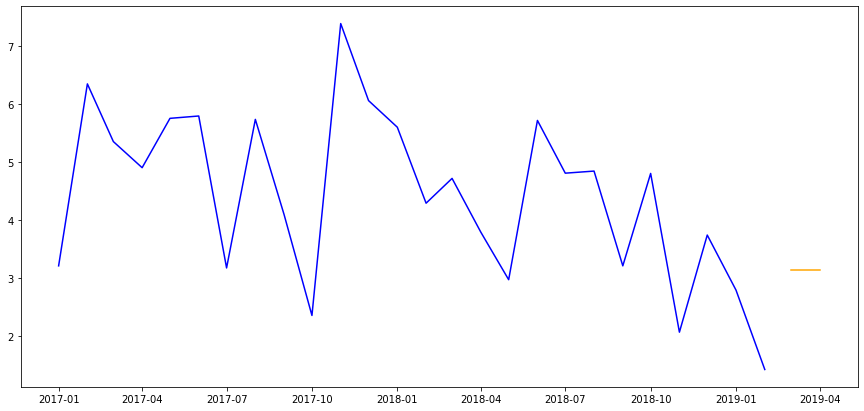

610 ) 20729
620 ) 20744
630 ) 20763
640 ) 20778


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


650 ) 20790


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


660 ) 20805


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


670 ) 20820


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


680 ) 20835
690 ) 20849
700 ) 20865


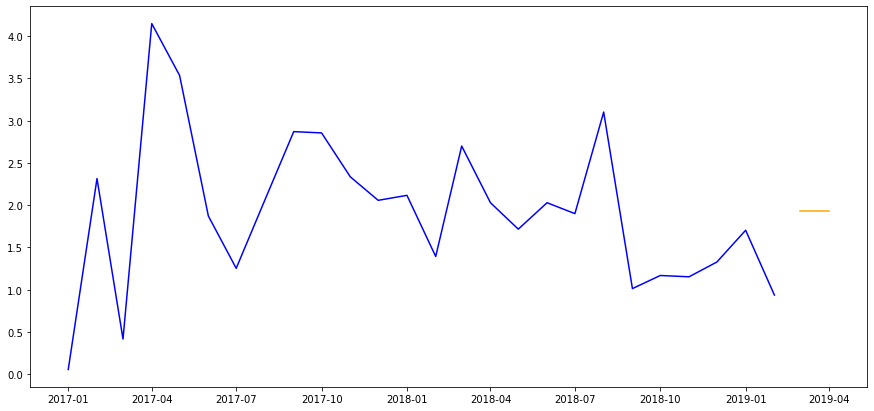

C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


710 ) 20885


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be g

720 ) 20905
730 ) 20931
740 ) 20949
750 ) 20969
760 ) 20985
770 ) 21001
780 ) 21022


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


790 ) 21038


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


800 ) 21062


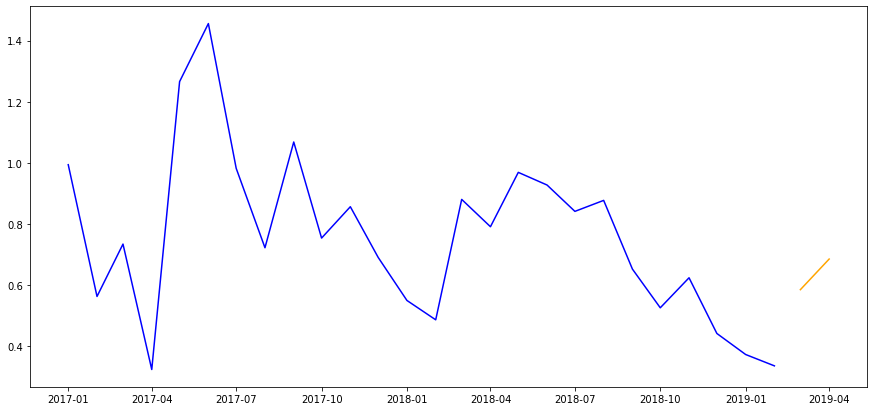

C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


810 ) 21102


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


820 ) 21133


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


830 ) 21168


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


840 ) 21191


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


850 ) 21212
860 ) 21248


C:\Users\dacastro\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [18]:
i = 0
for prod_id in df_test.product_id:
    if i%10==0:
        print(i,")", prod_id)
    
    df_arima = df_train[df_train.product_id==prod_id]
    df_arima.set_index(df_arima.periodo,inplace=True,drop=True)
    df_real = df_test[df_test.product_id==prod_id]

    ARIMA_model = pm.auto_arima(df_arima['tn'], 
                      start_p=1, 
                      start_q=1,
                      test='kpss', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      #m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
    
    fitted = ARIMA_model.predict(n_periods=2, return_conf_int=False)
    df_arima_pred = df_arima_pred.append({"product_id":int(df_real.product_id),
                                          "cat1":df_real.iat[0,3],
                                          'tn_real': float(df_real.tn), 
                                          'tn_pred': float(fitted.tail(1))},
                                        ignore_index=True)


    if i%100==0:
        ## Plot
        index_of_fc = pd.date_range(df_arima.periodo.max() + pd.DateOffset(months=1), periods = 2, freq='MS')
        fitted_series = pd.Series(fitted, index=index_of_fc)
        plt.figure(figsize=(15,7))
        plt.plot(df_arima["periodo"],df_arima["tn"], color='blue')
        plt.plot(fitted_series, color='orange')  
        plt.show()
        
    i = i+1

In [19]:
print_error_rate_total_y_cat(df_arima_pred)

**Error Rate Total:** 30.68

**Error Rate por Categoría HC**: 27.88

**Error Rate por Categoría FOODS**: 33.89

**Error Rate por Categoría PC**: 36.88